# Explore here

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

Loading the dataset

In [ ]:
#This dataset is separated by ';'
df = pd.read_csv('../data/raw/bank-marketing-campaign-data.csv', sep=';', na_values = 'unknown')
pd.set_option('display.max_columns', None)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Now let's proceed with the data analysis

Declaring a new index for the data set, one that we can easily call and manipulate and adds a unique identifier to each customer

In [96]:
#First let's reset the already defined index (0, 1, 2...)
df.reset_index(drop=True, inplace=True)

#Now let's define the new index
df['customer_id'] = df.index

#Now let's set the new index
df.set_index('customer_id', inplace=True)

#Now just to make sure that the new index is customer_id we tell pandas what is going on more explicity
df.index.name = 'customer_id'

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
customer_id,,,,,,,,,,,,,,,,,,,,,
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Now that we have a clear visual of the dataset let's proceed with the analysis and EDA

First thing will be to check those NaN values that we can see appear multiple times throug the df

In [97]:
#Checking where those NaN values appear

#Confirming the amount of null values
print(F"Amount of null values (NaN) is: {df.isnull().sum().sum()}\n")

print(F"Distribution of those null values (NaN):\n{df.isnull().sum()[df.isnull().sum() > 0]}")

Amount of null values (NaN) is: 12718

Distribution of those null values (NaN):
job           330
marital        80
education    1731
default      8597
housing       990
loan          990
dtype: int64


In [98]:
#Let's check for correlation between the NaNs in each variable

#Columns to check
columns_to_check = ['default', 'education', 'housing', 'loan', 'job']

#Function to compare 'y' outcome for missing vs non-missing
for col in columns_to_check:
    print(f"\n  Column: {col}")
    missing_group = df[df[col].isna()]
    non_missing_group = df[df[col].notna()]
    
    #Counting the values for missing_rate and non_missing_rate
    missing_rate = missing_group['y'].value_counts(normalize=True).get('yes', 0) * 100
    non_missing_rate = non_missing_group['y'].value_counts(normalize=True).get('yes', 0) * 100
    
    print(f"  Missing values: {missing_group.shape[0]}")
    print(f"    Deposit rate (y = yes): {missing_rate:.2f}%")
    print(f"  Non-missing values: {non_missing_group.shape[0]}")
    print(f"    Deposit rate (y = yes): {non_missing_rate:.2f}%")



  Column: default
  Missing values: 8597
    Deposit rate (y = yes): 5.15%
  Non-missing values: 32591
    Deposit rate (y = yes): 12.88%

  Column: education
  Missing values: 1731
    Deposit rate (y = yes): 14.50%
  Non-missing values: 39457
    Deposit rate (y = yes): 11.12%

  Column: housing
  Missing values: 990
    Deposit rate (y = yes): 10.81%
  Non-missing values: 40198
    Deposit rate (y = yes): 11.28%

  Column: loan
  Missing values: 990
    Deposit rate (y = yes): 10.81%
  Non-missing values: 40198
    Deposit rate (y = yes): 11.28%

  Column: job
  Missing values: 330
    Deposit rate (y = yes): 11.21%
  Non-missing values: 40858
    Deposit rate (y = yes): 11.27%


<Axes: >

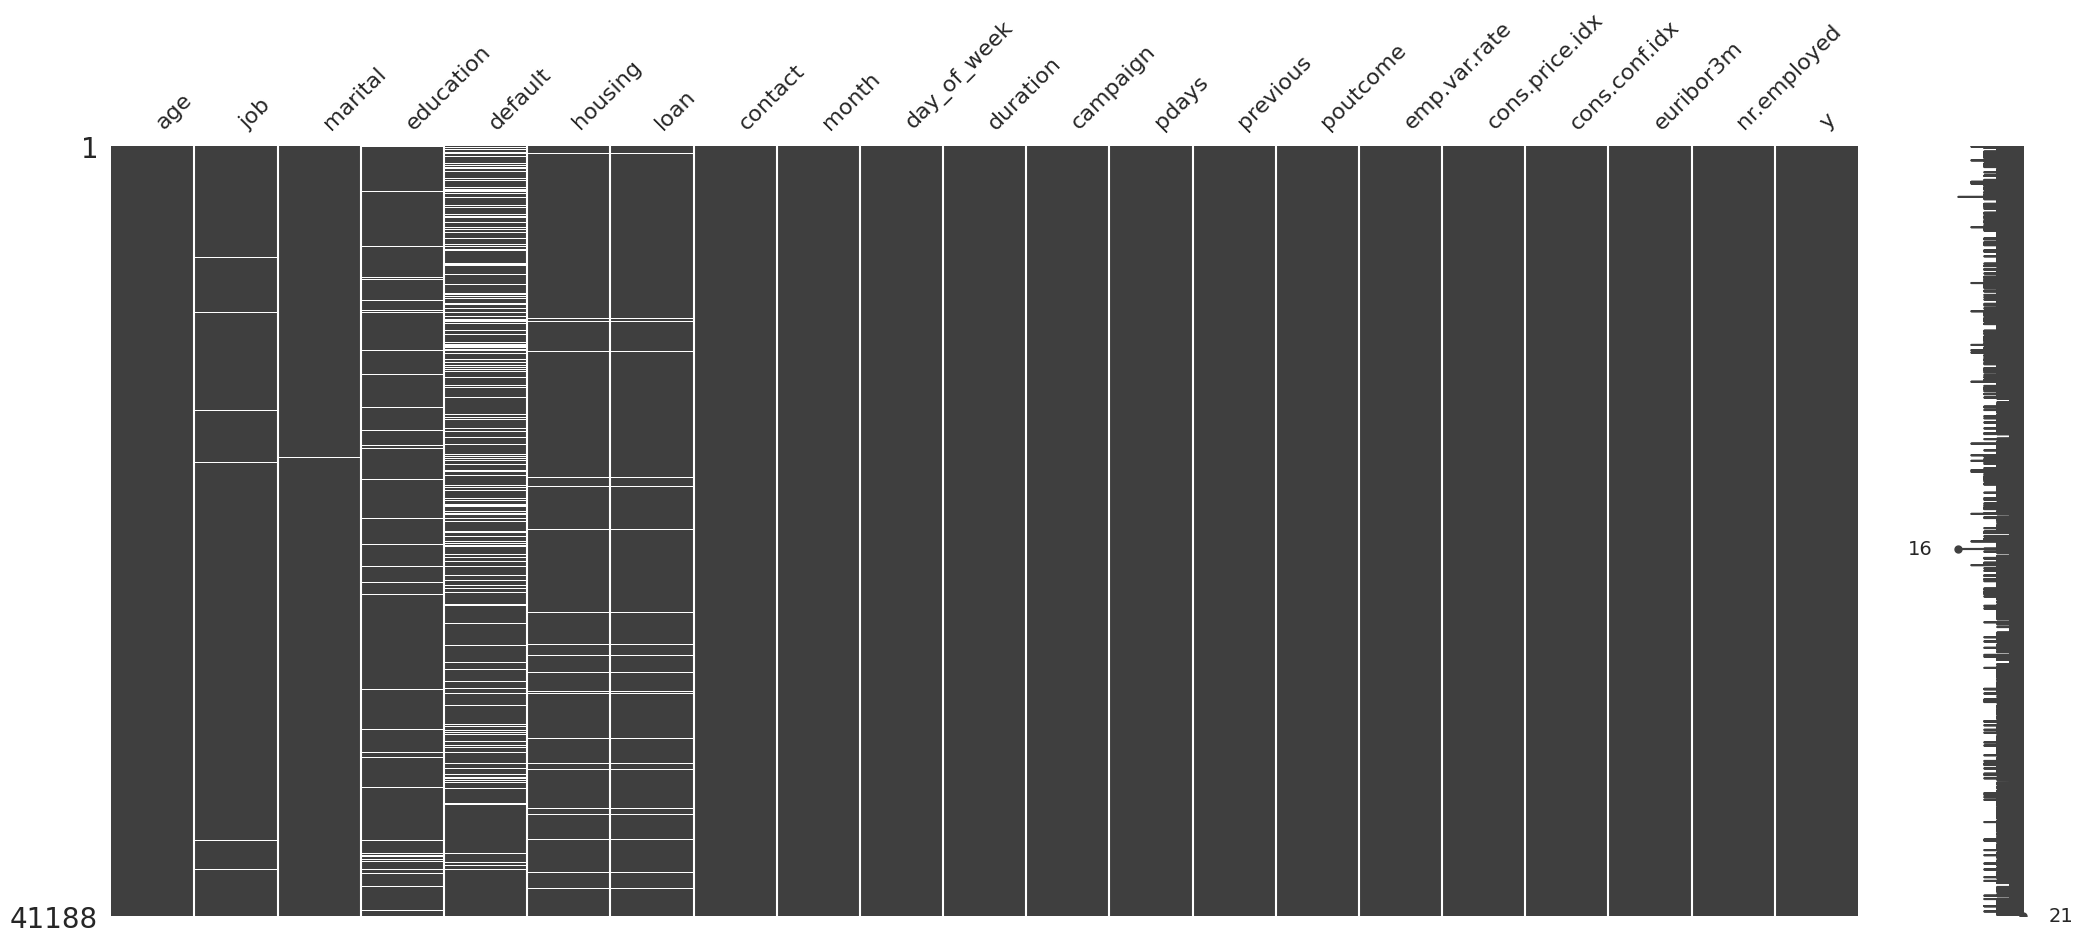

In [99]:
msno.matrix(df)

As we have multiple matching missing values we can identify a pattern but first, as I understand that the order of the categories is important to later use the encoders properly let's categorically organize the variables to mantain a logical sense in order to apply logistic or linear regression

In [100]:
#Mapping keys:values to later use a loop for encoding the values with respective numbers (Categorically organizing variables)

#Define mappings
ordinal_mappings = {
    'education': [
        'illiterate',
        'basic.4y',
        'basic.6y',
        'basic.9y',
        'high.school',
        'professional.course',
        'university.degree'
    ],
    'day_of_week': [
        'mon', 
        'tue', 
        'wed',
        'thu',
        'fri'
    ],  
    'month': [
        'mar', 
        'apr', 
        'may', 
        'jun',
        'jul', 
        'aug', 
        'sep', 
        'oct', 
        'nov', 
        'dec'
    ]
}

#Apply encoding and print the mappings using the categorical method from pandas
for col, order in ordinal_mappings.items():
    df[col] = pd.Categorical(df[col], categories=order, ordered=True)
    df[col + '_encoded'] = df[col].cat.codes

    #Print the mapping
    print(f"\nMapping for column '{col}':")
    mapping = {cat: code for code, cat in enumerate(order)}
    for k, v in mapping.items():
        print(f"  {k}: {v}")




Mapping for column 'education':
  illiterate: 0
  basic.4y: 1
  basic.6y: 2
  basic.9y: 3
  high.school: 4
  professional.course: 5
  university.degree: 6

Mapping for column 'day_of_week':
  mon: 0
  tue: 1
  wed: 2
  thu: 3
  fri: 4

Mapping for column 'month':
  mar: 0
  apr: 1
  may: 2
  jun: 3
  jul: 4
  aug: 5
  sep: 6
  oct: 7
  nov: 8
  dec: 9


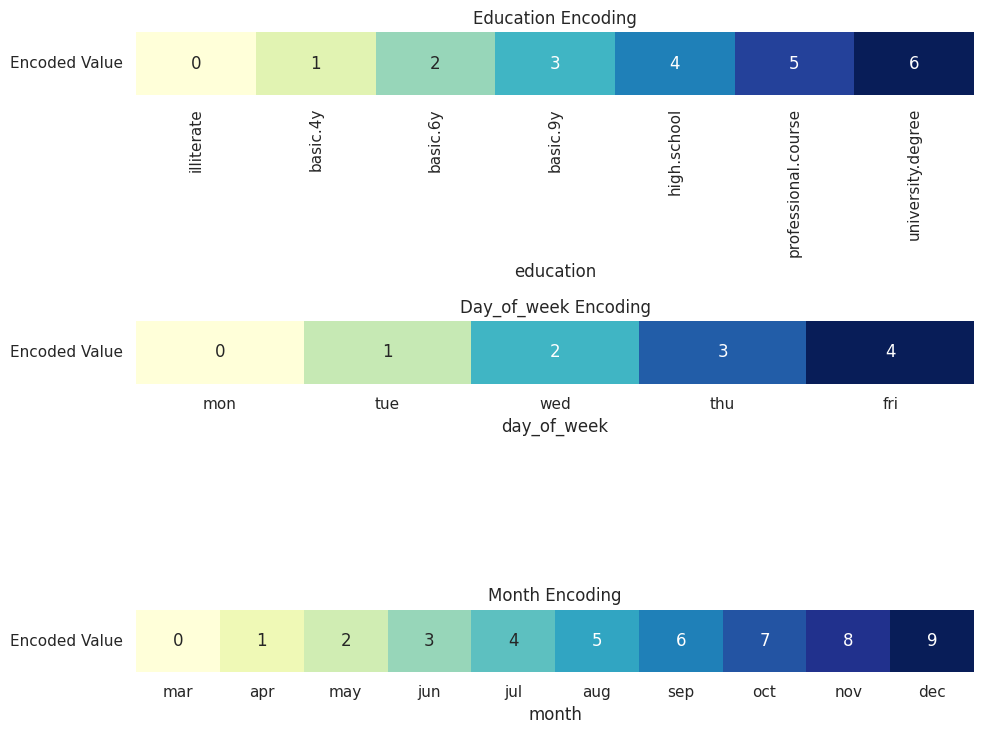

In [101]:
#Visual mapping representation

#Creates a list of maped DataFrames
mapping_dfs = []

#Loop through each category and create a DataFrame of mappings
for feature, order in ordinal_mappings.items():
    mapping_df = pd.DataFrame({
        feature: order,
        'Encoded Value': range(len(order))
    }).set_index(feature).T
    mapping_dfs.append((feature, mapping_df))

#Setup subplots
fig, axes = plt.subplots(len(mapping_dfs), 1, figsize=(10, 2.5 * len(mapping_dfs)))

#If only 1 plot, convert axes to list for consistent iteration
if len(mapping_dfs) == 1:
    axes = [axes]

#Plot each mapped value as a heatmap
for ax, (feature, df_) in zip(axes, mapping_dfs):
    sns.heatmap(df_, annot=True, fmt='d', cbar=False, cmap="YlGnBu", ax=ax)
    ax.set_title(f"{feature.capitalize()} Encoding", fontsize=12)
    ax.set_ylabel("")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

As we have mapped the categorically organized values let's now visualize the missing values distribution

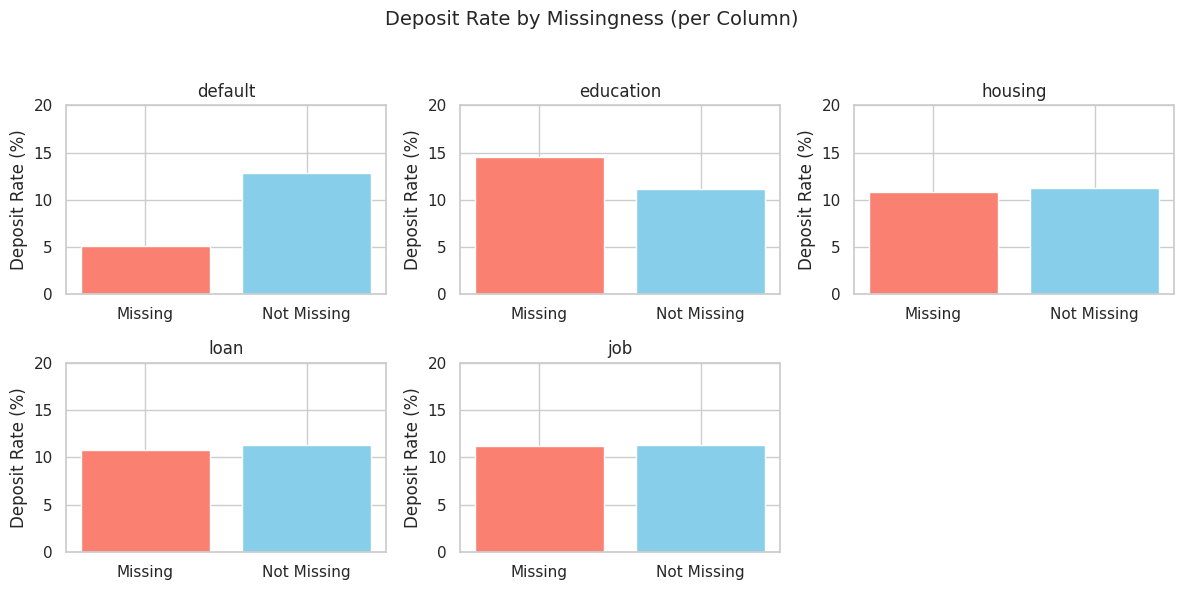

In [102]:
#Visualization of missing values distribution

#Columns to check and plot
columns_to_check = ['default', 'education', 'housing', 'loan', 'job']

#Subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()  #Making indexing easier

for i, col in enumerate(columns_to_check):
    missing_group = df[df[col].isna()]
    non_missing_group = df[df[col].notna()]

    missing_rate = missing_group['y'].value_counts(normalize=True).get('yes', 0) * 100
    non_missing_rate = non_missing_group['y'].value_counts(normalize=True).get('yes', 0) * 100

    #Subplots visualiizatiion
    axes[i].bar(['Missing', 'Not Missing'], [missing_rate, non_missing_rate],
                color=['salmon', 'skyblue'])
    axes[i].set_title(f'{col}')
    axes[i].set_ylim(0, max(missing_rate, non_missing_rate, 15) + 5)
    axes[i].set_ylabel('Deposit Rate (%)')

#Remove unused subplot if columns < number of axes
for j in range(len(columns_to_check), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Deposit Rate by Missingness (per Column)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for title
plt.show()



Missing Value Analysis & Decisions

During exploratory data analysis, several columns in the dataset were found to have missing values (originally encoded as 'unknown'). To determine whether these missing values were informative for our predictive model we analyzed the deposit rate (y = yes) for missing vs non-missing values.

``default``:

Missing: 8,597 rows

Deposit rate (missing): 5.15%

Deposit rate (non-missing): 12.88%

Decision: Keep missing values as "unknown" the difference is large and may contain useful signal.

``education``:

Missing: 1,731 rows

Deposit rate (missing): 14.5%

Deposit rate (non-missing): 11.12%

Decision: Keep missing values as "unknown" the higher deposit rate may be predictive.

``housing``:

Missing: 990 rows

Deposit rate difference is small.

Decision: Impute missing values using the mode.

``loan``:

Missing: 990 rows

Deposit rate difference is small.

Decision: Impute missing values using the mode.

``job``:

Missing: 330 rows

Deposit rate difference is negligible.

Decision: Impute missing values using the mode.

In [103]:
#Replacing NaNs in housing, loan and job with the most common value

#List of columns to impute with mode
mode_impute_cols = ['housing', 'loan', 'job']

#Impute each column with its mode
for col in mode_impute_cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

#Checking that there are no more NaNs 
print(df[mode_impute_cols].isnull().sum())

housing    0
loan       0
job        0
dtype: int64


In [104]:
#Analysis of the ds shape (how many rows and columns)
df.shape

(41188, 24)

We can see that we are working with 41188 rows that represents customers, therefore we have, in theory 41188 customers with information collected into 21 variables being almost equally splitted into categorical(11) and numerical(10)

In [105]:
#Analysis of the ds information 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41188 entries, 0 to 41187
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  41188 non-null  int64   
 1   job                  41188 non-null  object  
 2   marital              41108 non-null  object  
 3   education            39457 non-null  category
 4   default              32591 non-null  object  
 5   housing              41188 non-null  object  
 6   loan                 41188 non-null  object  
 7   contact              41188 non-null  object  
 8   month                41188 non-null  category
 9   day_of_week          41188 non-null  category
 10  duration             41188 non-null  int64   
 11  campaign             41188 non-null  int64   
 12  pdays                41188 non-null  int64   
 13  previous             41188 non-null  int64   
 14  poutcome             41188 non-null  object  
 15  emp.var.rate         411

After printing the ds info we can observe that the dataset in question is full of information except from Default and Education variables that contain some NaN's. Also, there are multiple duplicated values as we are replying to the same questions over 41.000 diifferent customer (age, marital, housing, etc)

In [106]:
#Checking for duplicated values
df.duplicated().sum()

np.int64(12)

We have 12 duplicated rows so let's analyze those dup rows 

In [107]:
#Checking for unique values inside the ds
df.nunique()

age                      78
job                      11
marital                   3
education                 7
default                   2
housing                   2
loan                      2
contact                   2
month                    10
day_of_week               5
duration               1544
campaign                 42
pdays                    27
previous                  8
poutcome                  3
emp.var.rate             10
cons.price.idx           26
cons.conf.idx            26
euribor3m               316
nr.employed              11
y                         2
education_encoded         8
day_of_week_encoded       5
month_encoded            10
dtype: int64

We have multiple variables with constant values and this is due to the fact that those variables contain in resume a yes or no value (0 or 1), let's understand how balanced or imbalanced each feature is by checking the distribution of those values

In [108]:
#Printing the value counts to check the distribution balance
print(F"Default column distribution:\n{df['default'].value_counts(normalize=True) * 100}\n")

print(F"Housing column distribution:\n{df['housing'].value_counts(normalize=True) * 100}\n")

print(F"Loan column distribution:\n{df['loan'].value_counts(normalize=True) * 100}\n")

print(F"Contact column distribution:\n{df['contact'].value_counts(normalize=True) * 100}")

Default column distribution:
default
no     99.990795
yes     0.009205
Name: proportion, dtype: float64

Housing column distribution:
housing
yes    54.787802
no     45.212198
Name: proportion, dtype: float64

Loan column distribution:
loan
no     84.830533
yes    15.169467
Name: proportion, dtype: float64

Contact column distribution:
contact
cellular     63.474798
telephone    36.525202
Name: proportion, dtype: float64


Let's plot that distribution for a visual understanding 

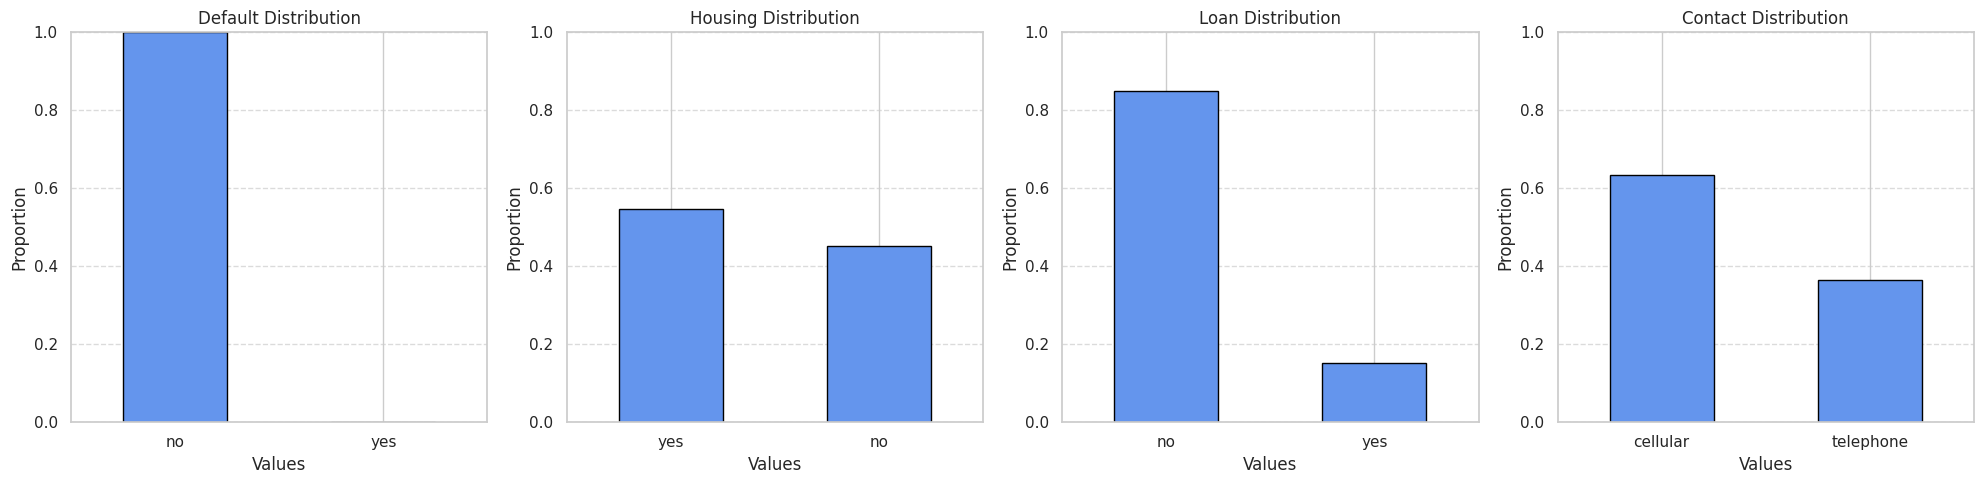

In [109]:
#Plots for better understanding of the value distribution 

#Define the categorical columns to plot (Using enumerate)
cols = ['default', 'housing', 'loan', 'contact']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))  

#Looping through each column and plot on the corresponding subplot
for i, col in enumerate(cols):
    df[col].value_counts(normalize=True).plot(
        kind='bar',
        ax=axes[i],
        color='cornflowerblue',
        edgecolor='black'
    )
    axes[i].set_title(f'{col.capitalize()} Distribution')
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Proportion')
    axes[i].set_ylim(0, 1)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].tick_params(axis='x', rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()

Analysis of the Distribution: 

We can extract some usefuel information from this balances, starting with Default that makes references to a customer having credit, we can see that almost every customer (99.9%) does not have credit, while only 0.01% do. This feature is extremely imbalanced. Having credit could significantly affect the likelihood of taking out a long-term deposit, even if the group is small, however, the 0.01% does not represent a solid group to work with.

Going over to housing we can see that there is a relatively balanced distribution here, with 54% of customers having a housing loan and 46% without. This balance suggests the feature may help in identifying patterns, particularly among the 46% who don’t have a housing loan, and how that correlates with taking a long-term deposit. Hence, this column should be kept and encoded in the future.

As the third one, Loan, we can clearly see there is a noticeable imbalance: 84% of customers do not have a personal loan, while 15% do. Despite the imbalance, the presence of a personal loan could influence financial decisions and impact whether a customer agrees to a long-term deposit. For this reason, this column will also be retained and encoded as well.

And finally we can analyze the contact column that the majority of contacts were made via cellular phone (63%), with the remaining 37% through telephone. While the distribution is skewed, it reflects actual marketing campaign strategy and could provide insights into the effectiveness of communication channels.

Now let's take a look into the statistics 

In [110]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


Describe analysis:

Age: The average customer is around 40, and most are under 47. There’s a wide age range (from 17 to 98), so we have a mix of younger and older adults.

Duration: This column has a huge spread and some extreme values (up to 4918 seconds).

Campaign: On average, people were contacted about 2–3 times, but some up to 56! I’ll likely cap this feature to reduce the effect of outliers.

Pdays & Previous: Most customers were never contacted before (999 shows that). I’ll combine these into a binary variable to simplify things; 1 if they were contacted before, 0 if not.

Emp.var.rate: This reflects economic conditions. Negative values might point to tough times, which could impact deciisions about long-term deposits.

Cons.price.idx & Cons.conf.idx: Price index is quite stable, but consumer confidence tends to be low that might affect how people respond to offers.

Euribor3m: This is one of the most important features (economically speaking). It’s related to interest rates, which strongly affect saving behavior.

Nr.employed: The number of employees varies slightly but might be useful for segmenting people based on the economic environment at the time.

Visual interpretation of the descriptive analysis

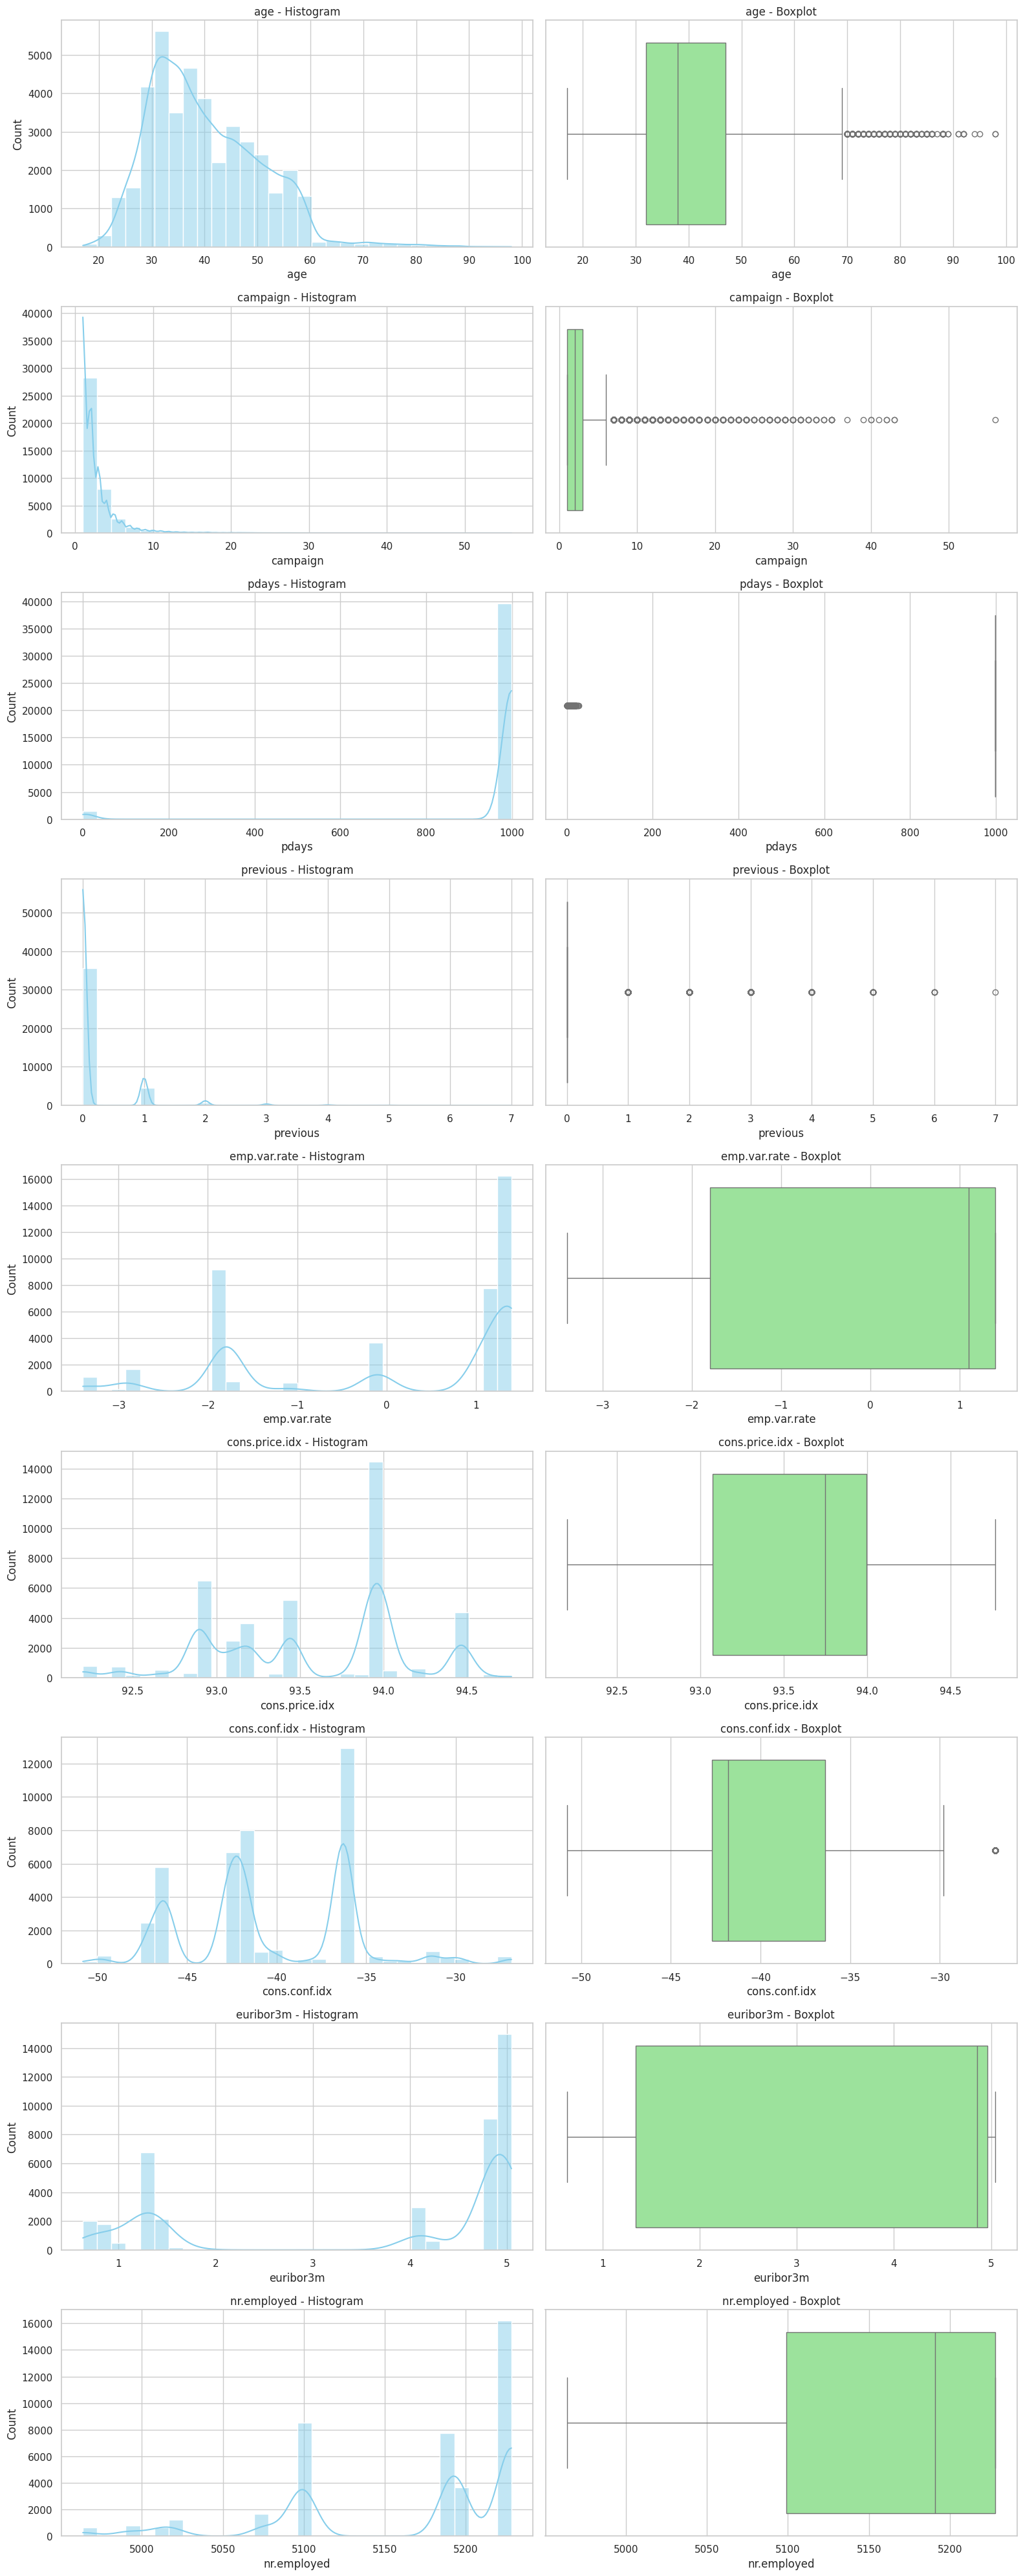

In [111]:
#List of numeric columns to visualize
num_cols = [
    'age', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]

sns.set(style="whitegrid")
plt.figure(figsize=(16, 40))

#Subplots with loop to go over each enumerated variable
for i, col in enumerate(num_cols):
    #Histograms
    plt.subplot(len(num_cols), 2, 2*i + 1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'{col} - Histogram')
    plt.xlabel(col)
    plt.ylabel('Count')

    #Boxplots
    plt.subplot(len(num_cols), 2, 2*i + 2)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'{col} - Boxplot')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


As we have analyzed the stats and we have a clear understanding of what are we working with, let's proceed with the encodiing of numerical variables

In [112]:
#Swaping values to binary values as those column only contain two posible values
bin_cols = ['loan', 'housing','y']
for col in bin_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_encoded,day_of_week_encoded,month_encoded
customer_id,,,,,,,,,,,,,,,,,,,,,,,,
0,56,housemaid,married,basic.4y,no,0,0,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1,0,2
1,57,services,married,high.school,NaN,0,0,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2
2,37,services,married,high.school,no,1,0,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2
3,40,admin.,married,basic.6y,no,0,0,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2,0,2
4,56,services,married,high.school,no,0,1,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2


In [113]:
#Creation of a new column for pdays where the condition is if there was a contact then value that contact to 0, otherwise if there was contact 1
df['encoded_pdays'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_encoded,day_of_week_encoded,month_encoded,encoded_pdays
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,
0,56,housemaid,married,basic.4y,no,0,0,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1,0,2,0
1,57,services,married,high.school,NaN,0,0,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2,0
2,37,services,married,high.school,no,1,0,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2,0
3,40,admin.,married,basic.6y,no,0,0,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2,0,2,0
4,56,services,married,high.school,no,0,1,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2,0


In [114]:
#Encoding of relevant numerical variables

le_job = LabelEncoder()
le_marital = LabelEncoder()
le_contact = LabelEncoder()
le_poutcome = LabelEncoder()


df['encoded_job'] = le_job.fit_transform(df['job'])
df['encoded_marital'] = le_marital.fit_transform(df['marital'])
df['encoded_contact'] = le_contact.fit_transform(df['contact'])
df['encoded_poutcome'] = le_poutcome.fit_transform(df['poutcome'])


df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_encoded,day_of_week_encoded,month_encoded,encoded_pdays,encoded_job,encoded_marital,encoded_contact,encoded_poutcome
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,56,housemaid,married,basic.4y,no,0,0,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1,0,2,0,3,1,1,1
1,57,services,married,high.school,NaN,0,0,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2,0,7,1,1,1
2,37,services,married,high.school,no,1,0,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2,0,7,1,1,1
3,40,admin.,married,basic.6y,no,0,0,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2,0,2,0,0,1,1,1
4,56,services,married,high.school,no,0,1,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2,0,7,1,1,1


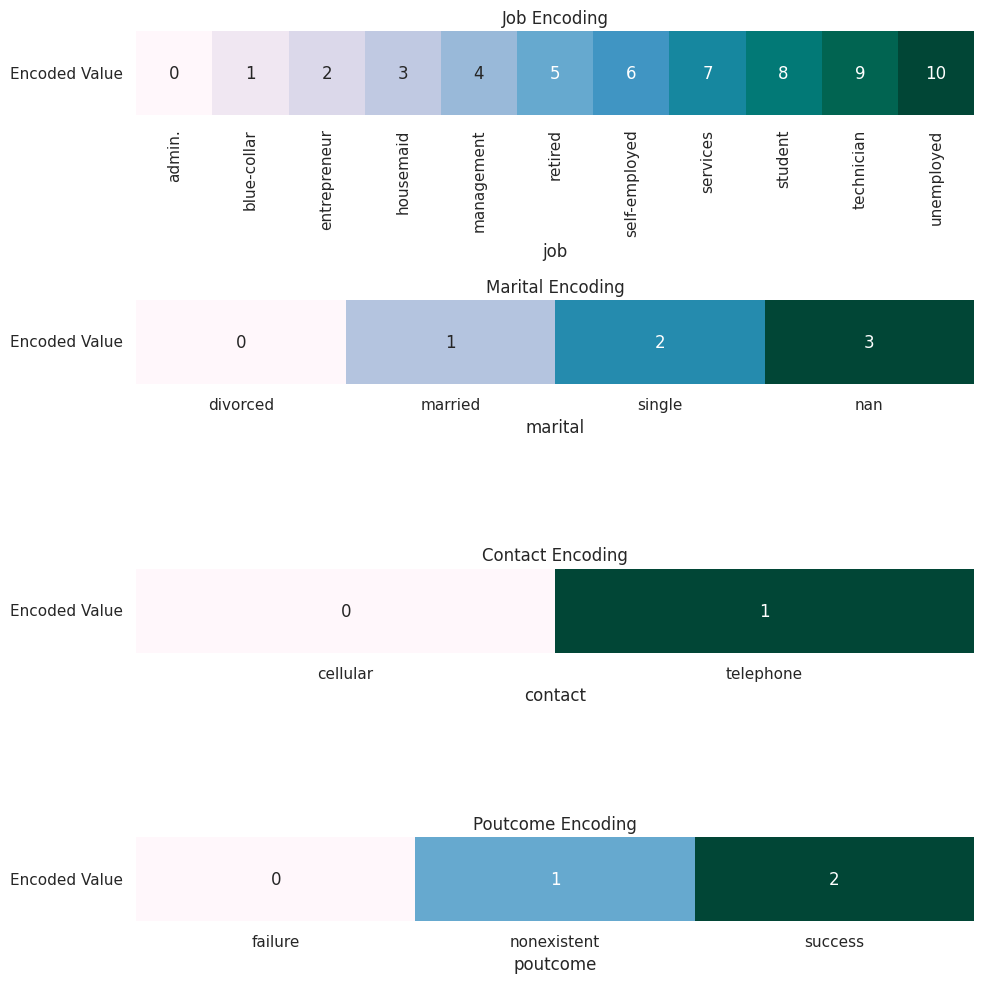

In [115]:
#Reconstruct mappings from LabelEncoders 
label_mappings = {
    'job': dict(zip(le_job.classes_, le_job.transform(le_job.classes_))),
    'marital': dict(zip(le_marital.classes_, le_marital.transform(le_marital.classes_))),
    'contact': dict(zip(le_contact.classes_, le_contact.transform(le_contact.classes_))),
    'poutcome': dict(zip(le_poutcome.classes_, le_poutcome.transform(le_poutcome.classes_)))
}

#Create a list of mapping DataFrames
mapping_dfs = []

#Loop through each label encoded mapping
for feature, mapping in label_mappings.items():
    mapping_df = pd.DataFrame({
        feature: list(mapping.keys()),
        'Encoded Value': list(mapping.values())
    }).set_index(feature).T
    mapping_dfs.append((feature, mapping_df))

#subplots
fig, axes = plt.subplots(len(mapping_dfs), 1, figsize=(10, 2.5 * len(mapping_dfs)))

#Ensuring axes are iterable
if len(mapping_dfs) == 1:
    axes = [axes]

#Plot each as a heatmap
for ax, (feature, df_) in zip(axes, mapping_dfs):
    sns.heatmap(df_, annot=True, fmt='d', cbar=False, cmap="PuBuGn", ax=ax)
    ax.set_title(f"{feature.capitalize()} Encoding", fontsize=12)
    ax.set_ylabel("")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

Now that we have successfully LabelEncoded the relevant numerical variables and added them as a new variable we can drop the original versions of those and drop a also the ones that will create to much noise or are not relevant for the model

In [116]:
df.drop(columns=['day_of_week','education','month','job','marital','contact','poutcome', 'default', 'pdays'], inplace=True)
df.head()

,age,housing,loan,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_encoded,day_of_week_encoded,month_encoded,encoded_pdays,encoded_job,encoded_marital,encoded_contact,encoded_poutcome
customer_id,,,,,,,,,,,,,,,,,,,,
0,56,0,0,261,1,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,2,0,3,1,1,1
1,57,0,0,149,1,0,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2,0,7,1,1,1
2,37,1,0,226,1,0,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2,0,7,1,1,1
3,40,0,0,151,1,0,1.1,93.994,-36.4,4.857,5191.0,0,2,0,2,0,0,1,1,1
4,56,0,1,307,1,0,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2,0,7,1,1,1


DATA PARTITIONING

In [117]:
#Data partitioning (Saving the cleaned df)
cleaned_df = pd.DataFrame(df, index=df.index)
cleaned_df.to_csv('cleaned_df.csv')

cleaned_df.head()

,age,housing,loan,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_encoded,day_of_week_encoded,month_encoded,encoded_pdays,encoded_job,encoded_marital,encoded_contact,encoded_poutcome
customer_id,,,,,,,,,,,,,,,,,,,,
0,56,0,0,261,1,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,2,0,3,1,1,1
1,57,0,0,149,1,0,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2,0,7,1,1,1
2,37,1,0,226,1,0,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2,0,7,1,1,1
3,40,0,0,151,1,0,1.1,93.994,-36.4,4.857,5191.0,0,2,0,2,0,0,1,1,1
4,56,0,1,307,1,0,1.1,93.994,-36.4,4.857,5191.0,0,4,0,2,0,7,1,1,1


In [118]:
#Data partitioning (Splitting the df into the correspondent test and train categories and dropping the objective column)
X = cleaned_df.drop(['y'],axis=1)
y = cleaned_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
X_test.shape

(8238, 19)

In [120]:
X_train.shape

(32950, 19)

We can see that our variables are now splitted into X_test (8238 rows that makes the 20% of the "info") and X_train (32950 rows that makes the 80% of the "info")

Now let's proceed to instance the regresos and fit it our X_train and y_train. Create a new df with the importances and sort it by the same condition 

In [121]:
#Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)

#New DF with the importances 
dict_data = {'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100}
df_imp = pd.DataFrame(dict_data)

#sorting the df by importance 
df_imp.sort_values(by='Importance', ascending=False, inplace=True)

In [122]:
#Check those columns with an importance greater than 1%
df_imp[df_imp['Importance']>=1]

,Feature,Importance
10,nr.employed,63.213211
14,encoded_pdays,5.991021
3,duration,4.619976
18,encoded_poutcome,3.705012
8,cons.conf.idx,3.362947
7,cons.price.idx,2.757655
17,encoded_contact,2.042056
9,euribor3m,1.666557
12,day_of_week_encoded,1.423835
15,encoded_job,1.327243


We can identify that ``nr.employed`` stands out as the most influential variable by far, contributing over 63% of the total importance. While other features like ``encoded_pdays``, ``duration``, and ``encoded_poutcome`` follow with moderate influence, indicating that customer interaction history and campaign response behavior are relevant but less dominant factors.

Now let's further clean the importances df 

In [123]:
#Dropping the characteristics with an importance lower than 1 from test and train X
X_train.drop(df_imp[df_imp['Importance']<1]['Feature'], axis=1, inplace=True)
X_test.drop(df_imp[df_imp['Importance']<1]['Feature'], axis=1, inplace=True)

Let's proceed wiith the Variance Inflation Factor to measures how much a feature's variance is inflated due to multicollinearity with other features.

In [124]:
#VIF
vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif

age                        2.380047
loan                       1.005467
duration                   1.202101
campaign                   2.337352
emp.var.rate           13992.561244
cons.price.idx          1080.067165
cons.conf.idx            199.821526
euribor3m              40915.753528
nr.employed             9893.962370
education_encoded          1.547497
day_of_week_encoded        1.156971
month_encoded             88.150971
encoded_pdays              7.891560
encoded_job                1.117804
encoded_marital            2.108288
encoded_contact          124.631570
encoded_poutcome           4.745704
dtype: float64

The VIF analysis reveals significant multicollinearity among several features indicating strong linear relationships among them. Such high VIF values suggest redundancy. To improve model perfomance, let's investigate with a correlation plot and possibly remove or combine highly collinear features.

<Axes: >

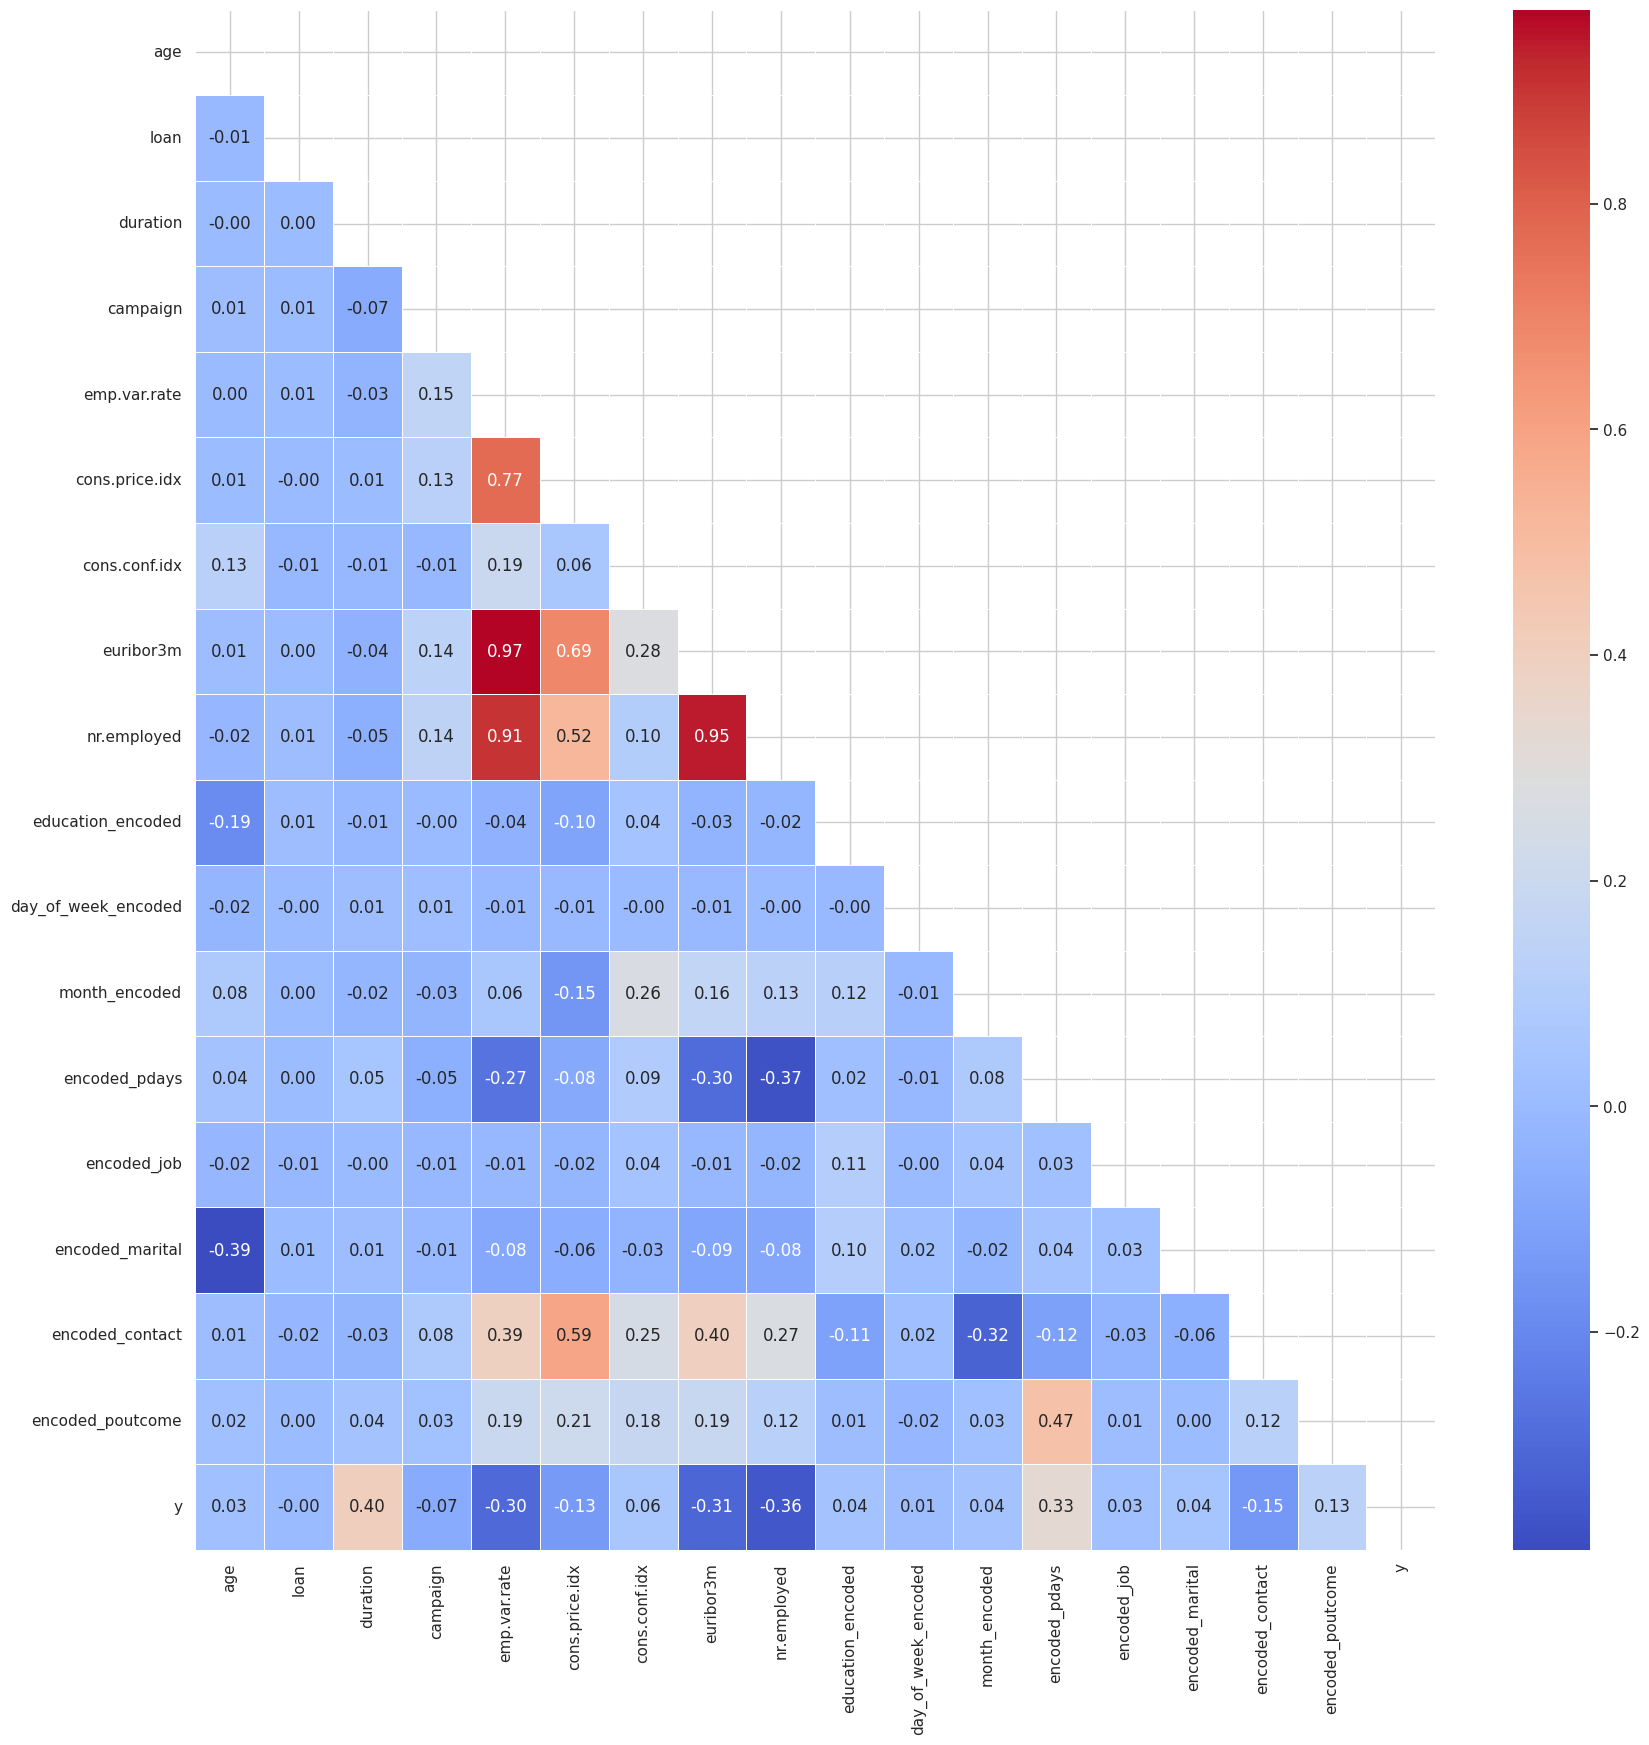

In [125]:
#Building the correlation plot
X_corr = X_train.copy()
X_corr['y'] = y_train
corr = X_corr.corr()

#Plot
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

In [126]:
#The variables nr.employed and euribor have a strong correlation so let's fix that by multiplying their values

#Firts let's drop a column that will not be useful from now on 
X_train1 = X_train.drop(['emp.var.rate'], axis=1)
X_test = X_test.drop(['emp.var.rate'], axis=1)


In [127]:
X_train1['employed_euribor'] = X_train['nr.employed'] * X_train['euribor3m']
X_train1.drop(['nr.employed','euribor3m'], axis=1, inplace=True)

X_test['employed_euribor'] = X_test['nr.employed'] * X_test['euribor3m']
X_test.drop(['nr.employed','euribor3m'], axis=1, inplace=True)

Let's analyze the VIF once again

In [128]:
vif = pd.Series([variance_inflation_factor(X_train1.corr().values, i) for i in range(X_train1.corr().shape[1])], index=X_train1.columns)
vif

age                     2.314472
loan                    1.004049
duration                1.060909
campaign                1.145068
cons.price.idx         29.459642
cons.conf.idx           4.435699
education_encoded       1.356704
day_of_week_encoded     1.009165
month_encoded           4.263411
encoded_pdays           7.841778
encoded_job             1.068036
encoded_marital         2.009367
encoded_contact        10.457184
encoded_poutcome        4.772029
employed_euribor       30.579831
dtype: float64

By creating the interaction term ``employed_euribor`` (a product of ``nr.employed`` and ``euribor3m``) and dropping the original highly collinear variables, the VIF values improved substantially. Specifically, extreme VIFs of ``euribor3m`` (40,916) and ``nr.employed`` (9,894) were eliminated, and the new variable ``employed_euribor`` introduced a much more manageable VIF of 30.6. This transformation significantly reduced multicollinearity.  Additionally, ``cons.price.idx`` dropped from 1,080 to 29.5, and ``encoded_contact`` from 125 to 10.5. Overall, the VIF distribution is now within acceptable bounds, improving the model’s stability and interpretability.

Let's visualize this modification with a correlation map 

<Axes: >

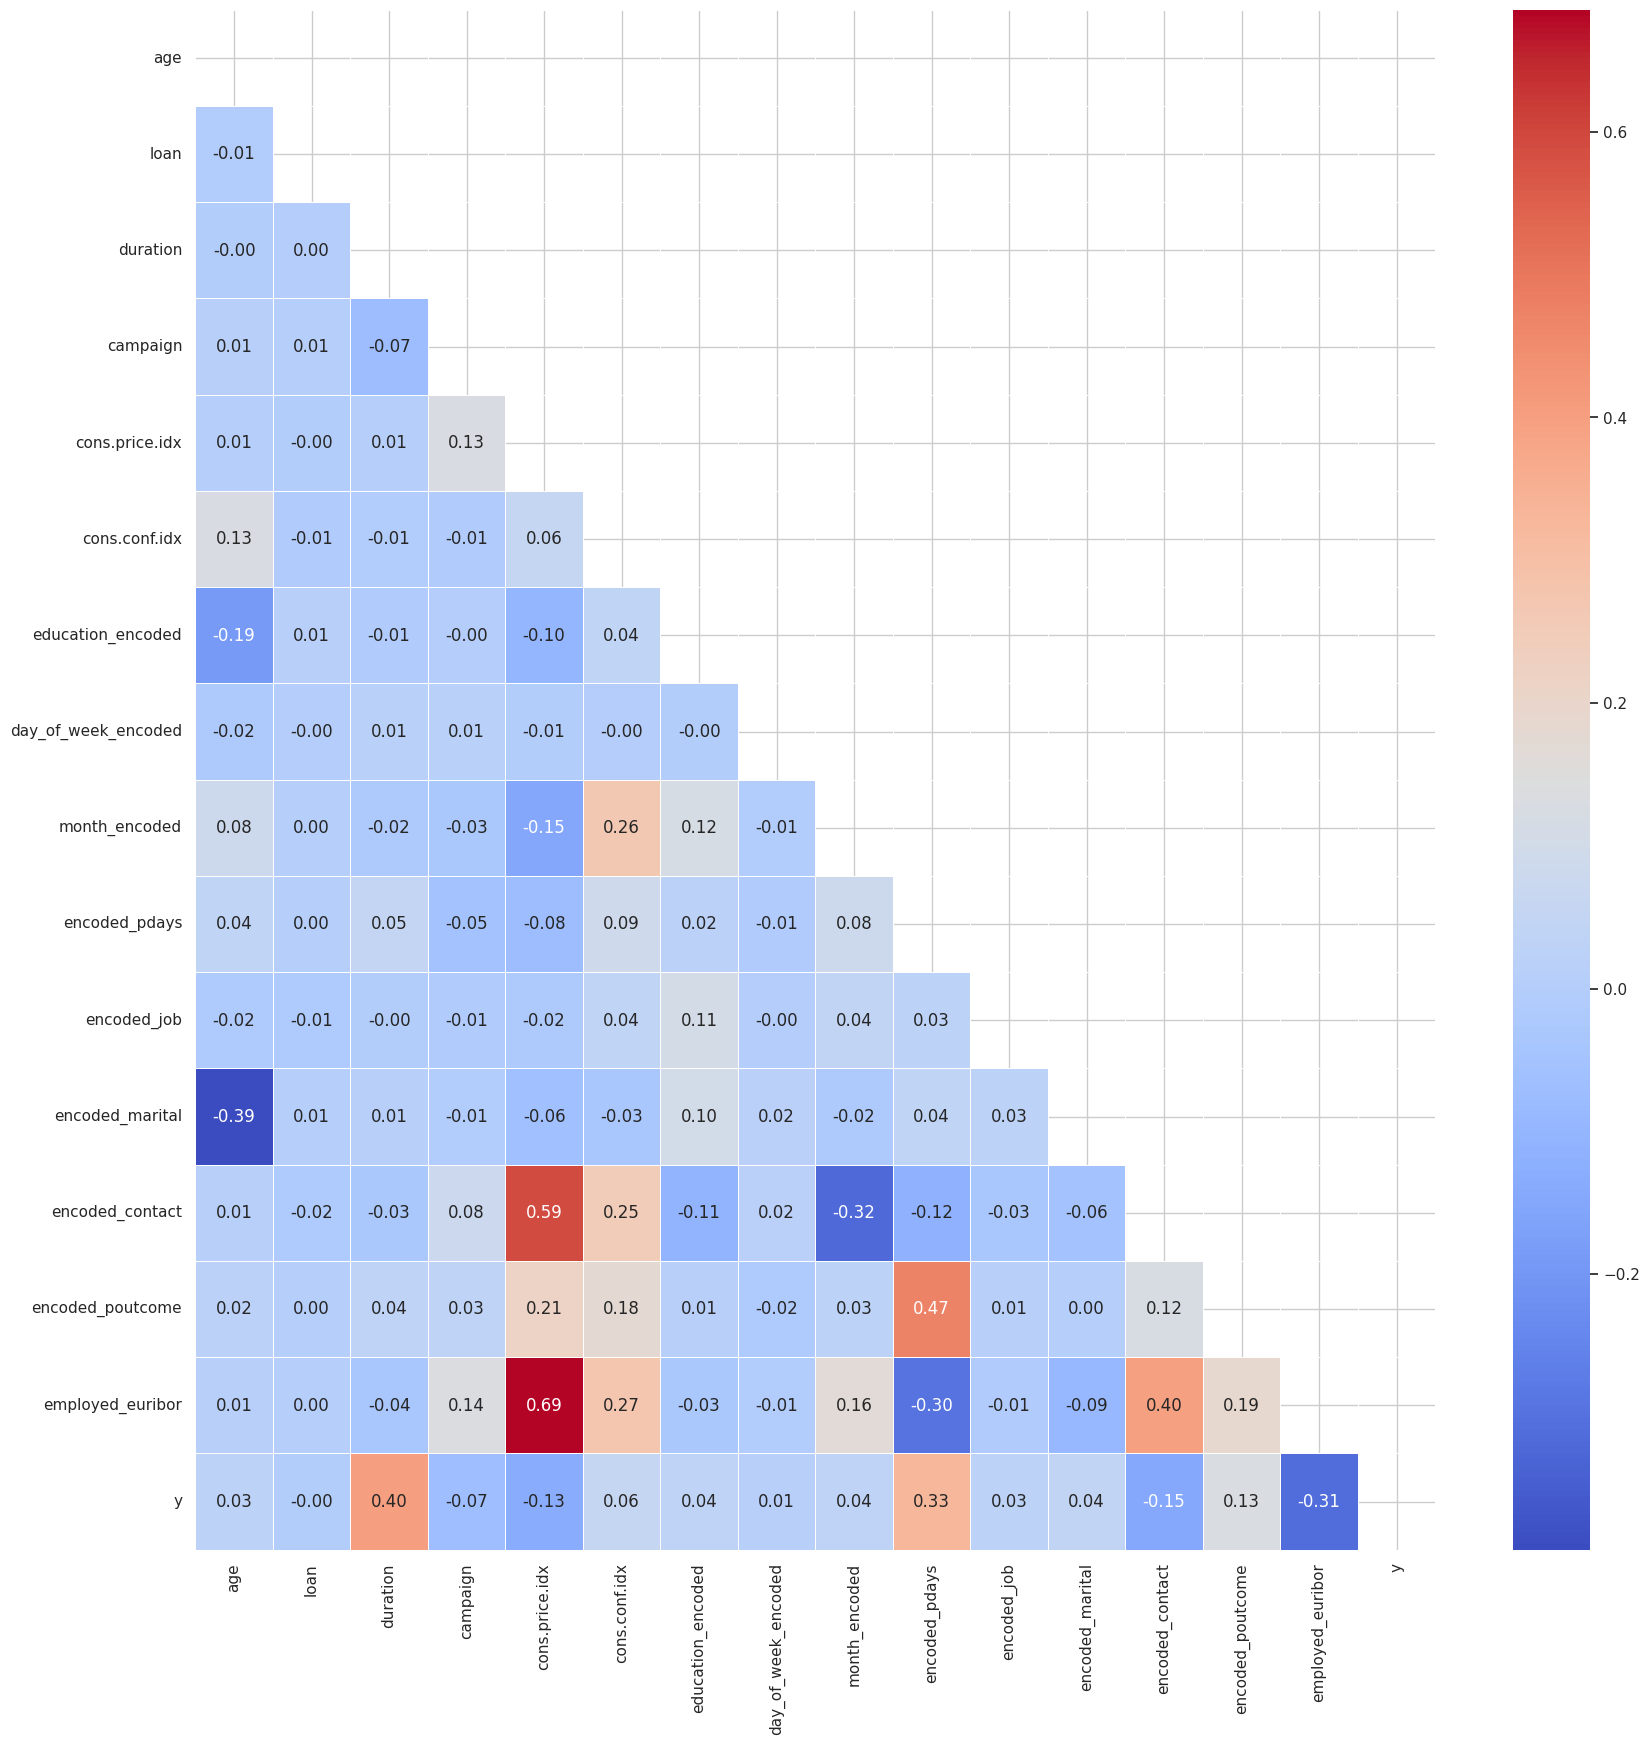

In [129]:
X_corr = X_train1.copy()
X_corr['y'] = y_train
corr = X_corr.corr()


mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

The next step  is to build the logistic regression model is to scale the data with the default hyperparms as instructed in the dashboard

In [130]:
#Instancing the scaler
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.fit_transform(X_test)

In [131]:
#Transforming the model with the scaled X_train and X_test
model = LogisticRegression()
model.fit(X_scaled, y_train)

LogisticRegression()

In [132]:
#Predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

#Basic metrics calculation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

#Printing of the metrics 
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.9146637533381888
Matriz de confusión:
 [[6997  306]
 [ 397  538]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      7303
           1       0.64      0.58      0.60       935

    accuracy                           0.91      8238
   macro avg       0.79      0.77      0.78      8238
weighted avg       0.91      0.91      0.91      8238

ROC AUC: 0.9265852945936071


Model performance analysis: 

The model is doing a good job overall, with an accuracy of 91.47% and a high ROC AUC score of 0.93, which means it can separate the two classes well. It's very good at predicting when a customer will not subscribe (class 0), but it's less accurate at finding the ones who will (class 1), with only 58% of the actual positive cases correctly identified. This is likely because there are fewer positive cases in the dataset. To improve the model, especially for class 1, I’ll use Randomized Search (This was decided based on the fact that the colleague that I was working with decided to use the Grid Search method and we wanted to contrast the algorithms performance) to tune the hyperparameters and try different algorithms to find a better-performing model.

In [133]:
#We define the parameters we want to adjust

hyperparams = {
    "C": np.logspace(-4, 4, 20),
    "penalty": ["l1", "l2", "elasticnet", None],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

#Initialize the random search 
random_search = RandomizedSearchCV(model, hyperparams, n_iter = 100, scoring = "accuracy", cv = 5, random_state = 42)
random_search

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, scoring='accuracy')

In [134]:
#Fitting the data 
random_search.fit(X_scaled, y_train)

#Printing the best hyperparam
print(f"\nBest hyperparameters: {random_search.best_params_}")

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: U


Best hyperparameters: {'solver': 'lbfgs', 'penalty': None, 'C': np.float64(0.0006951927961775605)}


After the random search the results are that the best hyperparameters are: {'solver': 'lbfgs', 'penalty': None, 'C': np.float64(0.0006951927961775605)}. 

Let's apply the hyperparameters and test the model 

In [ ]:
#Testing the new model 
model1 = LogisticRegression(penalty= None, C=0.0006951927961775605, solver='lbfgs')
model1.fit(X_scaled, y_train)

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


LogisticRegression(C=0.0006951927961775605, penalty=None)

In [ ]:
#Predictions

y_pred1 = model1.predict(X_test_scaled)
y_prob1 = model1.predict_proba(X_test_scaled)[:, 1]

#Basic metrics calculation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

#Printing the metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.9146637533381888
Matriz de confusión:
 [[6997  306]
 [ 397  538]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      7303
           1       0.64      0.58      0.60       935

    accuracy                           0.91      8238
   macro avg       0.79      0.77      0.78      8238
weighted avg       0.91      0.91      0.91      8238

ROC AUC: 0.9265852945936071


After tuning the logistic regression model using Randomized Search, the best hyperparameters found were: solver='lbfgs', penalty=None, and C ≈ 0.0007. With these settings, the model reached an accuracy of 91.47% and a ROC AUC of 0.93, which shows it still performs very well at distinguishing between customers who will and won’t subscribe. It continues to predict class 0 (non-subscribers) very accurately, with 95% precision and 96% recall. For class 1 (subscribers), performance improved slightly compared to earlier models, with precision of 64% and recall of 58%, though it's still an area to improve. This tuning helped confirm the model is already quite strong.

Let's visualize the differences in performance with a bar chart

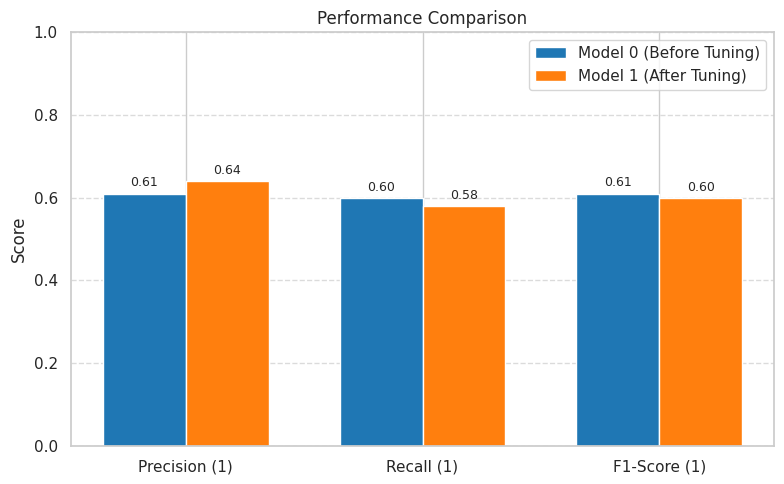

In [139]:
#Data
labels = ['Precision (1)', 'Recall (1)', 'F1-Score (1)']
before = [0.61, 0.60, 0.61]
after = [0.64, 0.58, 0.60]

x = np.arange(len(labels))
width = 0.35

#Setup
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, before, width, label='Model 0 (Before Tuning)', color='#1f77b4')
bars2 = ax.bar(x + width/2, after, width, label='Model 1 (After Tuning)', color='#ff7f0e')

#T and labels
ax.set_ylabel('Score')
ax.set_title('Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

#For value labels on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
#Creating a contrast df to show contrast between both models

#Define metrics
metrics = ['Accuracy', 'Precision (1)', 'Recall (1)', 'F1-Score (1)', 'ROC AUC']
model_0 = [0.9117, 0.61, 0.60, 0.61, 0.9268]
model_1 = [0.9147, 0.64, 0.58, 0.60, 0.9266]

# Create table
comparison_df = pd.DataFrame(
    {
    'Metric': metrics,
    'Model 0 (Before Tuning)': model_0,
    'Model 1 (After Tuning)': model_1
}
)

#Formating float precision to show 4 decimals
pd.options.display.float_format = "{:.4f}".format

#Saving the new comparison df 
df.to_csv('model_comparison.csv', index=False)

comparison_df.head()

,Metric,Model 0 (Before Tuning),Model 1 (After Tuning)
0,Accuracy,0.9117,0.9147
1,Precision (1),0.6100,0.6400
2,Recall (1),0.6000,0.5800
3,F1-Score (1),0.6100,0.6000
4,ROC AUC,0.9268,0.9266


Model Comparison 

After evaluating both models, we found that Model 0 achieved an accuracy of 91.17%, while Model 1, which was fine-tuned using Random Search for hyperparameter optimization, slightly improved overall accuracy to 91.46%. However, this small gain came at a cost in the model's ability to detect positive cases (customers who will make a long-term deposit, which is our main business goal).

In Model 0, the recall for class 1 (positive class) was 0.60, while in Model 1 it decreased to 0.58. Precision slightly improved from 0.61 to 0.64, but the recall drop means we miss more actual depositors, which is a critical loss for a marketing or campaign targeting scenario. In real-world terms, missing a potential customer who would have said "yes" to a deposit is more damaging than incorrectly targeting someone who ultimately won't.

Despite the marginally better accuracy and precision in Model 1, Model 0 offers a better balance of sensitivity to depositors, which aligns with the goal of minimizing false negatives.



Final Decision

My final decision will be to choose Model 0 as I care more about not missing potential depositors